In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
filenames = [
    'NF-UNSW-NB15-v3',
    'NF-BoT-IoT-v3',
    'NF-CICIDS2018-v3',
    # 'NF-ToN-IoT-v3'
]

list_of_dfs = []

print("Iniciando o carregamento dos arquivos...")
for filename in filenames:
    path = f'db/{filename}.csv'
    print(f"  -> Carregando: {path}")
    try:
        temp_df = pd.read_csv(path)
        list_of_dfs.append(temp_df)
    except FileNotFoundError:
        print(f"  -> AVISO: O arquivo {path} não foi encontrado e será ignorado.")

In [ ]:
print("Concatenando os dataframes...")
df = pd.concat(list_of_dfs, ignore_index=True)
df = shuffle(df, random_state=42).reset_index(drop=True)
print(f"Processo finalizado! O dataframe final contém {len(df)} linhas.")

In [ ]:
df = list_of_dfs[2]

In [2]:
filename = 'my_data'

df = pd.read_csv(f'db/{filename}.csv')

In [3]:
df.drop(['IPV4_SRC_ADDR',
         'IPV4_DST_ADDR',
         'L4_SRC_PORT',
         'L4_DST_PORT',
         'L7_PROTO',
         'TCP_FLAGS',
         'CLIENT_TCP_FLAGS',
         'SERVER_TCP_FLAGS',
         'MIN_TTL', 
         'MAX_TTL',
         'SHORTEST_FLOW_PKT',
         'MIN_IP_PKT_LEN', 
         'TCP_WIN_MAX_IN', 
         'TCP_WIN_MAX_OUT', 
         'DNS_QUERY_ID', 
         'DNS_TTL_ANSWER',
         'FTP_COMMAND_RET_CODE',
         'SRC_TO_DST_SECOND_BYTES',
         'DST_TO_SRC_SECOND_BYTES',
         'FLOW_START_MILLISECONDS',
         'FLOW_END_MILLISECONDS',], inplace=True, axis=1)

In [4]:
dictionary_sets_by_attack_type = {}
attack_types = df['Attack'].unique()

In [5]:
for attack_type in attack_types:
    print(f"Processando a categoria: '{attack_type}'")
    df_current_attack = df[df['Attack'] == attack_type]

    df_train_current_attack, df_aux_current_attack = train_test_split(df_current_attack, train_size=0.5, random_state=42)
    df_test_current_attack, df_val_current_attack = train_test_split(df_aux_current_attack, train_size=0.5, random_state=42)

    dictionary_sets_by_attack_type[attack_type] = {
        'treino': df_train_current_attack,
        'teste': df_test_current_attack,
        'validacao': df_val_current_attack
    }
    print(f"  -> Treino: {len(df_train_current_attack)} | Teste: {len(df_test_current_attack)} | Validação: {len(df_val_current_attack)}")


Processando a categoria: 'Benign'
  -> Treino: 9902173 | Teste: 4951086 | Validação: 4951087
Processando a categoria: 'DoS'
  -> Treino: 4020085 | Teste: 2010042 | Validação: 2010043
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando a categoria: 'Reconnaissance'
  -> Treino: 856103 | Teste: 428051 | Validação: 428052
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'Infilteration'
  -> Treino: 94076 | Teste: 47038 | Validação: 47038
Processando a categoria: 'Bot'
  -> Treino: 103851 | Teste: 51926 | Validação: 51926
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino

In [6]:
list_train = [dictionary_sets_by_attack_type[attack_type]['treino'] for attack_type in attack_types]
df_train = pd.concat(list_train)

list_test = [dictionary_sets_by_attack_type[attack_type]['teste'] for attack_type in attack_types]
df_test = pd.concat(list_test)

list_val = [dictionary_sets_by_attack_type[attack_type]['validacao'] for attack_type in attack_types]
df_val = pd.concat(list_val)

In [7]:
print(f"--- Base de Treino ---")
print(f"Tamanho: {len(df_train)} linhas")
print(f"Categorias presentes: {df_train['Attack'].unique()}")
print(df_train['Attack'].value_counts())
print("-" * 25)

print(f"\n--- Base de Teste ---")
print(f"Tamanho: {len(df_test)} linhas")
print(f"Categorias presentes: {df_test['Attack'].unique()}")
print(df_test['Attack'].value_counts())
print("-" * 25)

print(f"\n--- Base de Validação ---")
print(f"Tamanho: {len(df_val)} linhas")
print(f"Categorias presentes: {df_val['Attack'].unique()}")
print(df_val['Attack'].value_counts())
print("-" * 25)

--- Base de Treino ---
Tamanho: 19707377 linhas
Categorias presentes: ['Benign' 'DoS' 'DDOS_attack-HOIC' 'Reconnaissance' 'DDoS' 'Infilteration'
 'Bot' 'FTP-BruteForce' 'SSH-Bruteforce' 'DoS_attacks-Hulk'
 'DDoS_attacks-LOIC-HTTP' 'DoS_attacks-SlowHTTPTest'
 'DoS_attacks-GoldenEye' 'Exploits' 'DoS_attacks-Slowloris' 'Fuzzers'
 'Generic' 'Backdoor' 'DDOS_attack-LOIC-UDP' 'Brute_Force_-Web' 'Theft'
 'Shellcode' 'Analysis' 'SQL_Injection' 'Brute_Force_-XSS' 'Worms']
Attack
Benign                      9902173
DoS                         4020085
DDoS                        3575441
Reconnaissance               856103
DDOS_attack-HOIC             516155
FTP-BruteForce               193360
DDoS_attacks-LOIC-HTTP       144294
Bot                          103851
SSH-Bruteforce                94237
Infilteration                 94076
DoS_attacks-SlowHTTPTest      52775
DoS_attacks-Hulk              50038
DoS_attacks-GoldenEye         30650
Exploits                      21374
DoS_attacks-Slowloris

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
scaler = MinMaxScaler()

In [10]:
df_train_benign = df_train[df_train['Attack'] == 'Benign']
df_train_attacks = df_train[df_train['Attack'] != 'Benign']

rus = df_train_attacks['Attack'].value_counts().min()
if rus < 1000:
    rus = 1000

df_train_attacks_balanced = df_train_attacks.groupby('Attack').sample(n=rus, replace=True, random_state=42)

num_attack_classes = len(df_train_attacks['Attack'].unique())
num_benign_samples = num_attack_classes * rus
df_train_benign_sampled = df_train_benign.sample(n=num_benign_samples, random_state=42)

df_train = pd.concat([df_train_attacks_balanced, df_train_benign_sampled])
df_train = shuffle(df_train, random_state=42).reset_index(drop=True)

X_train = df_train.drop(['Label', 'Attack'], axis=1)
y_train = df_train['Label'].to_numpy()

X_train = scaler.fit_transform(X_train)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

In [11]:
df_train['Label'].value_counts()

Label
0    25000
1    25000
Name: count, dtype: int64

In [12]:
df_train['Attack'].value_counts()

Attack
Benign                      25000
DoS                          1000
Analysis                     1000
DoS_attacks-SlowHTTPTest     1000
DoS_attacks-GoldenEye        1000
Brute_Force_-XSS             1000
DDOS_attack-LOIC-UDP         1000
Backdoor                     1000
Infilteration                1000
FTP-BruteForce               1000
DoS_attacks-Slowloris        1000
Worms                        1000
DDOS_attack-HOIC             1000
Brute_Force_-Web             1000
SSH-Bruteforce               1000
DoS_attacks-Hulk             1000
Shellcode                    1000
Exploits                     1000
Generic                      1000
SQL_Injection                1000
Bot                          1000
DDoS_attacks-LOIC-HTTP       1000
Fuzzers                      1000
DDoS                         1000
Theft                        1000
Reconnaissance               1000
Name: count, dtype: int64

In [13]:
len(X_train)

50000

In [14]:
X_train.shape

torch.Size([50000, 33])

In [15]:
y_train.unique(return_counts=True)

(tensor([0, 1]), tensor([25000, 25000]))

In [16]:
X_train.min(), X_train.max(), X_train.mean()

(tensor(0.), tensor(1.), tensor(0.0418))

In [17]:
X_test = df_test.drop(['Label', 'Attack'], axis=1)
y_test = df_test['Label'].to_numpy()

rus = RandomUnderSampler(random_state = 42)
X_test, y_test = rus.fit_resample(X_test, y_test)

X_test = scaler.transform(X_test)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [18]:
df_test['Label'].value_counts()

Label
0    4951086
1    4902600
Name: count, dtype: int64

In [19]:
df_test['Attack'].value_counts()

Attack
Benign                      4951086
DoS                         2010042
DDoS                        1787720
Reconnaissance               428051
DDOS_attack-HOIC             258078
FTP-BruteForce                96680
DDoS_attacks-LOIC-HTTP        72147
Bot                           51926
SSH-Bruteforce                47118
Infilteration                 47038
DoS_attacks-SlowHTTPTest      26387
DoS_attacks-Hulk              25019
DoS_attacks-GoldenEye         15325
Exploits                      10687
DoS_attacks-Slowloris          9010
Fuzzers                        8454
Generic                        4913
Backdoor                       1165
DDOS_attack-LOIC-UDP            862
Shellcode                       595
Brute_Force_-Web                404
Theft                           404
Analysis                        306
Brute_Force_-XSS                120
SQL_Injection                   110
Worms                            39
Name: count, dtype: int64

In [20]:
len(X_test)

9805200

In [21]:
X_test.shape

torch.Size([9805200, 33])

In [22]:
y_test.unique(return_counts=True)

(tensor([0, 1]), tensor([4902600, 4902600]))

In [23]:
X_test.min(), X_test.max(), X_test.mean()

(tensor(-3.7146e-05), tensor(13.9267), tensor(0.0412))

In [24]:
X_val = df_val.drop(['Label', 'Attack'], axis=1)
y_val = df_val['Label'].to_numpy()

rus = RandomUnderSampler(sampling_strategy={0: 25000, 1: 25000}, random_state = 42)
X_val, y_val = rus.fit_resample(X_val, y_val)

X_val = scaler.transform(X_val)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

In [25]:
len(X_val)

50000

In [26]:
y_val.unique(return_counts=True)

(tensor([0, 1]), tensor([25000, 25000]))

In [27]:
X_val.min(), X_val.max(), X_val.mean()

(tensor(-8.0685e-06), tensor(1.0001), tensor(0.0413))

In [52]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

NEW_BATCH_SIZE = 64 

train_loader = DataLoader(train_dataset, batch_size=NEW_BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=NEW_BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=NEW_BATCH_SIZE, shuffle=False, num_workers=8)

In [53]:
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 2

class IDSBranchyNet(nn.Module):
    def __init__(self):
        super(IDSBranchyNet, self).__init__()
        self.main_part1 = nn.Sequential(
            nn.Linear(NUM_FEATURES, 82),
            nn.ReLU()
        )
        self.main_part2 = nn.Sequential(
            nn.Linear(82, 512),
            nn.ReLU(),
            nn.Linear(512, NUM_CLASSES)
        )
        self.branch = nn.Sequential(
            nn.Linear(82, 41),
            nn.ReLU(),
            nn.Linear(41, NUM_CLASSES)
        )

    def forward(self, x, part="both", intermediate_output=None):
        if part == "branch":
            intermediate_output = self.main_part1(x)
            branch_output = self.branch(intermediate_output)
            return branch_output, intermediate_output

        if part == "main":
            main_output = self.main_part2(intermediate_output)
            return main_output
        
        if part == "both":
            intermediate_output = self.main_part1(x)
            branch_output = self.branch(intermediate_output)
            main_output = self.main_part2(intermediate_output)
            return [branch_output, main_output]

model = IDSBranchyNet()
print(model)

IDSBranchyNet(
  (main_part1): Sequential(
    (0): Linear(in_features=33, out_features=82, bias=True)
    (1): ReLU()
  )
  (main_part2): Sequential(
    (0): Linear(in_features=82, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
  (branch): Sequential(
    (0): Linear(in_features=82, out_features=41, bias=True)
    (1): ReLU()
    (2): Linear(in_features=41, out_features=2, bias=True)
  )
)


In [54]:
model = IDSBranchyNet()

In [55]:
def train_model(model, train_loader, val_loader, epochs, weight_branch, weight_main, lr, device, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs, "both")
            loss_branch = criterion(outputs[0], labels)
            loss_main = criterion(outputs[1], labels)

            total_loss = (weight_branch * loss_branch) + (weight_main * loss_main)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, "both")
                loss_branch = criterion(outputs[0], labels)
                loss_main = criterion(outputs[1], labels)
                
                total_loss = (weight_branch * loss_branch) + (weight_main * loss_main)
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss_history, val_loss_history

In [56]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            start_time = time.perf_counter()
            
            branch_output, intermediate_output = model(samples, "branch")
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = trusts > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                intermediate_to_main = intermediate_output[main_branch_mask]
                
                main_output = model(None, "main", intermediate_to_main)
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp)
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples
        }

In [49]:
modelname = 'AMBOS'
modelname

'AMBOS'

In [50]:
teste_id = 5
teste_id

5

Epoch [1/150], Train Loss: 0.6893, Validation Loss: 0.6830
Epoch [2/150], Train Loss: 0.6788, Validation Loss: 0.6641
Epoch [3/150], Train Loss: 0.6627, Validation Loss: 0.6354
Epoch [4/150], Train Loss: 0.6433, Validation Loss: 0.6003
Epoch [5/150], Train Loss: 0.6251, Validation Loss: 0.5655
Epoch [6/150], Train Loss: 0.6109, Validation Loss: 0.5361
Epoch [7/150], Train Loss: 0.6004, Validation Loss: 0.5142
Epoch [8/150], Train Loss: 0.5925, Validation Loss: 0.4938
Epoch [9/150], Train Loss: 0.5862, Validation Loss: 0.4822
Epoch [10/150], Train Loss: 0.5809, Validation Loss: 0.4685
Epoch [11/150], Train Loss: 0.5762, Validation Loss: 0.4566
Epoch [12/150], Train Loss: 0.5718, Validation Loss: 0.4492
Epoch [13/150], Train Loss: 0.5676, Validation Loss: 0.4428
Epoch [14/150], Train Loss: 0.5636, Validation Loss: 0.4328
Epoch [15/150], Train Loss: 0.5601, Validation Loss: 0.4273
Epoch [16/150], Train Loss: 0.5560, Validation Loss: 0.4256
Epoch [17/150], Train Loss: 0.5522, Validation Lo

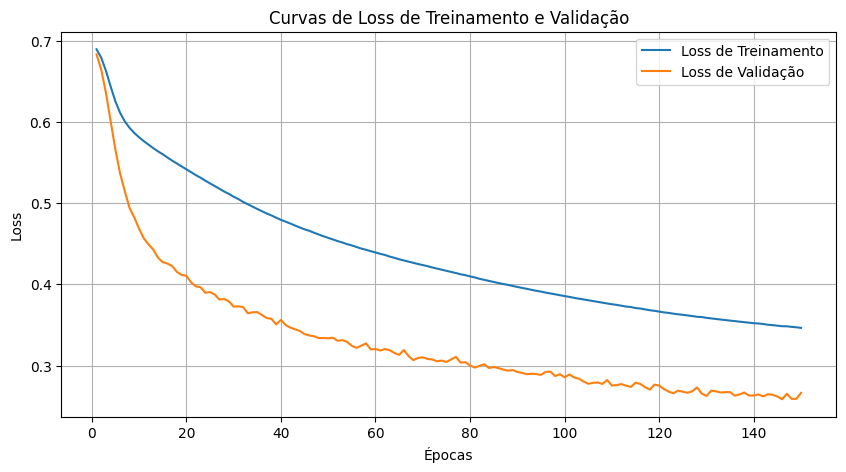


Modelo treinado e salvo em 'models/24_10/teste5/AMBOS.pth'


In [51]:
epochs = 150

train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, weight_branch=0, weight_main=1, lr=0.00001, device=device)

torch.save(model.state_dict(), f'models/24_10/teste{teste_id}/{modelname}.pth')
print(f"\nModelo treinado e salvo em 'models/24_10/teste{teste_id}/{modelname}.pth'")

--- Evaluation on Test Set using DataLoader ---
Modelo 'models/24_10/teste1/AMBOS.pth' carregado


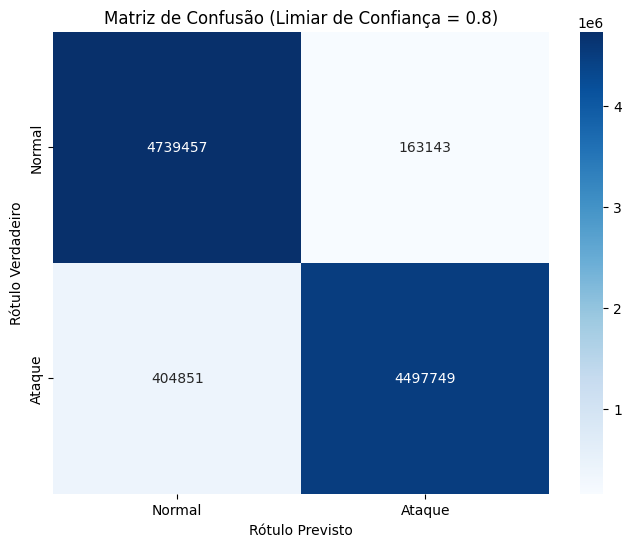

True Positives (TP): 4497749
True Negatives (TN): 4739457
False Positives (FP): 163143
False Negatives (FN): 404851

F1 Score: 0.9406
True Positive Rate (TPR) / Recall: 0.9174
True Negative Rate (TNR) / Specificity: 0.9667
--------------------
Threshold: 0.8
  Accuracy: 94.21%
  Avg. Inference Time: 0.0178 ms
  Early Exit Rate: 88.95% (8721523/9805200)
--------------------


In [60]:
print("--- Evaluation on Test Set using DataLoader ---")

model.load_state_dict(torch.load(f'models/24_10/teste{teste_id}/{modelname}.pth'))
print(f"Modelo 'models/24_10/teste{teste_id}/{modelname}.pth' carregado")


thresholds_to_test = [0.8]

for T in thresholds_to_test:
    results = evaluate_model(model, test_loader, confidence_threshold=T, device=device)
    print("-" * 20)
    print(f"Threshold: {T}")
    print(f"  Accuracy: {results['accuracy']:.2f}%")
    print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
    print(f"  Early Exit Rate: {results['exit_rate']:.2f}% ({results['exited_early_count']}/{results['total_samples']})")
    print("-" * 20)